In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences, peak_widths
from scipy.special import logsumexp
import scipy.interpolate
from scipy import integrate

%matplotlib inline
import mpld3
mpld3.enable_notebook()


# Load data 48 data
labels = ["phi", "ph2i", "phi3", "phi4", "kinetic", "ham", "op", "w"]
path_48_muca01="/home/koranna/Projects/scalnuc/run/bigmachine/run/b2_T93/Nx48_a1.5/muca01/"
path_48_muca0="/home/koranna/Projects/scalnuc/run/bigmachine/run/b2_T93/Nx48_a1.5/muca0/"

path_60_muca01="/home/koranna/Projects/scalnuc/run/bigmachine/run/b2_T93/Nx60_a1.5/muca01/"
path_60_muca0="/home/koranna/Projects/scalnuc/run/bigmachine/run/b2_T93/Nx60_a1.5/muca0/"

data48_0 = np.genfromtxt(path_48_muca0 + "data", names=labels)
data48_01 = np.genfromtxt(path_48_muca01 + "data", names=labels)

data60_0 = np.genfromtxt(path_60_muca0 + "data", names=labels)
data60_01 = np.genfromtxt(path_60_muca01 + "data", names=labels)

#points = np.genfromtxt(path_48_muca0 + "points", usecols=(1))
#points = np.transpose(points[np.newaxis]) # Flip the rows into columns

names = np.genfromtxt(path_48_muca0 + "params", usecols=0, dtype=str)
values48 = np.genfromtxt(path_48_muca0 + "params", usecols=1, dtype=float)
params48 = dict(zip(names, values48))
values60 = np.genfromtxt(path_60_muca0 + "params", usecols=1, dtype=float)
params60 = dict(zip(names, values60))

In [33]:
def find_extrema_index(x, y, crit, value):
    """
    Finding the extrema points from given data x,y
    crit is the approximate location for the critical bubble,
    usually set to 0.6
    Returns the index for symmetric, critical and broken phases
    """

    peaks, _ = find_peaks(y)
    #prominences = peak_prominences(y, peaks)[0]
    results_half = peak_widths(y, peaks, rel_height=1)

    peak_width = results_half[0]
    i_max = peak_width.argmax()
    peak_width[i_max]=0    # "Remove" the max value
    i_smax = peak_width.argmax()   # Find the second highest index
    i_max = peaks[i_max]    # Match them to the peak indices
    i_smax = peaks[i_smax]


    if value == 'half':
        i_s = i_max
        i_b = len(y)-1 #artifically set it to be the last point in the array

        y_ccut = y[i_s:]
        i_c = y_ccut.argmin()+i_s

    else:

        # Check which one is symmetric and which broken
        if i_max < i_smax:
            i_s = i_max
            i_b = i_smax
        else:
            i_s = i_smax
            i_b = i_max

        if (x[i_s]>crit):

            part=len(y[x<crit])
            y_scut = y[:part]
            i_s=y_scut.argmax()

            y_bcut = y[part:]
            i_b = y_bcut.argmax()+len(y_scut)

            y_ccut=y[i_s:i_b]
            i_c = y_ccut.argmin()+len(y[:i_s])

        else:
            y_cut = y[i_s:i_b]  # Find the minimun value between symmetric and broken
            k = len(y[0:i_s]) # Find how many indices were before symmetric phase
            i_c = y_cut.argmin()+k  # Sum them together to find the correct point

    return i_s, i_c, i_b


def gen_hist(data):
    y, binE = np.histogram(data["op"], bins=100, weights=np.exp(-data["w"]), density=True)
    # Generate the x-axis values
    x = 0.5*(binE[1:]+binE[:-1]) # Middle of the bins
    
    return x, y


def logtrapz(lnf, x):
    """
    Logarithmic integral, lnf is the logarithm of the function.
    Thank you Matt Pitkin on stackexchange
    https://math.stackexchange.com/questions/451771/how-to-numerically-integrate-expression-using-its-log-transform
    """
    # lnf[:-1] corrsponds to log of f(x_{k-1}) and lnf[1:] is lof of f(x_k) if you look at the wikipedia eq
    # and deltas is just delta x, and then taking a log of the whole eg yields
    deltas = np.log(np.diff(x))
    return -np.log(2.) + logsumexp([logsumexp(lnf[:-1]+deltas), logsumexp(lnf[1:]+deltas)])


def probability(x, y, epsilon, opC, index):
        """
        Calculates the probability part of the nucleation rate.
        That is the integrated ratio of P_op/(P_s*epsilon).
        """
        i_s, i_c, i_b = index
        i_low=i_c-5
        i_high=i_c+5

        #Probability of the symmetric phase (this is the easy well-behaving part)
        P_s=np.exp(logtrapz(np.log(y[:i_c]), x[:i_c]))

        # To avoid unnecessary runs, check if using the correct params file
        if epsilon==0:
            print("You are using a params file that has epsilon set to zero you dingus")
            sys.exit()

        # Makes sure our interpolation range is larger than epsilon
        while epsilon > np.abs(x[i_low]-x[i_high]):
            i_low= i_low-1
            i_high=i_high+1

        # Generate more data points to make the integration smoother
        new_length = 1000
        new_x = np.linspace(x[i_low], x[i_high], new_length)
        new_y = scipy.interpolate.interp1d(x[i_low-1:i_high+1], np.longdouble(y[i_low-1:i_high+1]), kind='nearest')(new_x)


        '''
        plt.figure()
        plt.plot(x,y)
        plt.plot(new_x,new_y, color='orange')
        plt.yscale('log')
        plt.show()
        plt.close()
        '''
        # Set the indices to actually match the epsilon range
        i_low = np.argwhere(new_x<=x[i_c]-epsilon/2)[-1][0]
        i_high = np.argwhere(new_x>=x[i_c]+epsilon/2)[0][0]
        # Probability of our bubble being in the critical phase (problem child)
        P_op=np.exp(logtrapz(np.log(new_y[i_low:i_high]), new_x[i_low:i_high]))
        
        #print(f"values inside epsilon {new_x[i_low:i_high]}")
        #print(f"epsilon based on interpolated data {np.abs(new_x[i_low]-new_x[i_high])}\n")
        #print(f"opC-epsilon/2 {opC-epsilon/2}, opC+epsilon/2 {opC+epsilon/2}\n")
    
        P=P_op/(P_s*epsilon)

        return P

epsilon: 0.01
1.026243120983861282e-28 -64.44647792513203586
7.100965026723993647e-29 -64.814737002759338996
epsilon: 0.001
6.9908227188697950236e-29 -64.830369448098511195
1.1364383613889499647e-28 -64.344483476463082125
-65.71944360094492409 -66.13970276808227356


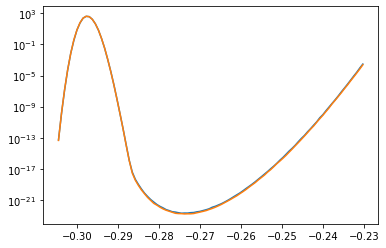

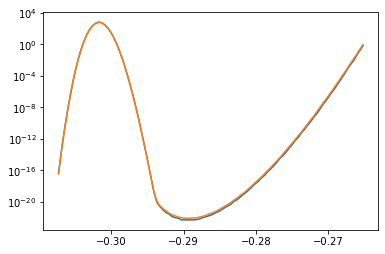

In [36]:
x_48_0, y_48_0 = gen_hist(data48_0)
x_48_01, y_48_01 = gen_hist(data48_01)

x_60_0, y_60_0 = gen_hist(data60_0)
x_60_01, y_60_01 = gen_hist(data60_01)

plt.figure(1)
plt.plot(x_48_0, y_48_0)
plt.plot(x_48_01, y_48_01)
plt.yscale('log')


plt.figure(2)
plt.plot(x_60_0, y_60_0)
plt.plot(x_60_01, y_60_01)
plt.yscale('log')

epsilon48 = params48["dOP"]
epsilon60 = params60["dOP"]
crit = 0.0
value = "half"
vol48 = (48*1.5)**3
vol60 = (60*1.5)**3

index = find_extrema_index(x_48_0, y_48_0, crit, value)
opC = x_48_0[index[1]]

print(f"epsilon: {epsilon48}")

probs48_0 = probability(x_48_0, y_48_0, epsilon48, opC, index)
print(probs48_0/vol48, np.log(probs48_0)-np.log(vol48))

index = find_extrema_index(x_48_01, y_48_01, crit, value)
opC = x_48_01[index[1]]

probs48_01 = probability(x_48_01, y_48_01, epsilon48, opC, index)
print(probs48_01/vol48, np.log(probs48_01)-np.log(vol48))


index = find_extrema_index(x_60_0, y_60_0, crit, value)
opC = x_60_0[index[1]]

print(f"epsilon: {epsilon60}")

probs60_0 = probability(x_60_0, y_60_0, epsilon60, opC, index)
print(probs60_0/vol60, np.log(probs60_0)-np.log(vol60))

index = find_extrema_index(x_60_01, y_60_01, crit, value)
opC = x_60_01[index[1]]

probs60_01 = probability(x_60_01, y_60_01, epsilon60, opC, index)
print(probs60_01/vol60, np.log(probs60_01)-np.log(vol60))

print(np.log(probs48_0*0.28/vol48), np.log(probs60_0*0.27/vol60))
